##ECE M214A Project: Speaker Region Identification



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import Audio

sr = 44100

# Audio(filename= "drive/MyDrive/code/214/project_data/train_clean/DCB_se1_ag1_f_03_1_seg_3.wav", rate=sr)

## 3. Feature Extraction

We first define a pair of functions to create features and labels for our classification model:


In [ ]:
!pip install opensmile

In [ ]:
import opensmile


def extract_smile(wav):

    audio,sample_fs = torchaudio.load(wav)

    sample_audio = audio.numpy().reshape(-1)

    smile = opensmile.Smile(
      feature_set=opensmile.FeatureSet.eGeMAPSv02,
      feature_level=opensmile.FeatureLevel.Functionals,
    )

    #opensmile.FeatureSet.ComParE_2016,
    #opensmile.FeatureSet.eGeMAPSv02
    y = smile.process_signal(
      sample_audio,
      sample_fs
    )
    # print(smile.feature_names)
    return np.array(y.iloc[0])

In [ ]:

import librosa
import torchaudio
import numpy as np
import scipy
from glob import glob
from tqdm import tqdm


def extract_feature(audio_file, n_mfcc=13):

  '''
  Function to extract features from a single audio file given its path
  Modify this function to extract your own custom features
  '''

  audio,fs = torchaudio.load(audio_file)
  audio = audio.numpy().reshape(-1)

  # replace the following features with your own
  pitches, magnitudes = librosa.core.piptrack(y=audio, sr=fs, fmin=40, fmax=500)
  # get indexes of the maximum value in each time slice
  max_indexes = np.argmax(magnitudes, axis=0)
  # get the pitches of the max indexes per time slice
  pitches = pitches[max_indexes, range(magnitudes.shape[1])]
  feat_out2 = np.mean(pitches,axis=0)
  mfccs = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=n_mfcc)
  feat_out1 = np.mean(mfccs,axis=1)
  feat_out2 = extract_smile(audio_file)
  feat_out = np.concatenate((feat_out1, feat_out2), axis=0)

  return feat_out2


def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DC' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  else:
    raise ValueError('invalid file name')
  return label

Let us now call these functions to extract the features and labels from the train_clean directory

In [ ]:

#First we obtain the list of all files in the train_clean directory
train_files = glob('drive/MyDrive/code/214/project_data/train_clean/*.wav')

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort() 

train_feat=[]
train_label=[]

for wav in tqdm(train_files):
  
  train_feat.append(extract_feature(wav))
  train_label.append(get_label(wav))

100%|██████████| 4372/4372 [00:00<00:00, 410363.36it/s]


In [ ]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob('drive/MyDrive/code/214/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort() 

test_clean_feat=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat.append(extract_feature(wav))
  test_clean_label.append(get_label(wav))

100%|██████████| 447/447 [00:00<00:00, 478279.05it/s]


In [ ]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob('drive/MyDrive/code/214/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort() 

test_noisy_feat=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):

  test_noisy_feat.append(extract_feature(wav))
  test_noisy_label.append(get_label(wav))

100%|██████████| 347/347 [00:00<00:00, 1065463.75it/s]


## 4. Model Training and Predictions

Now we'll train the backend system to predict the regions from the input features.  We'll use an xgboosted decision tree for this.  An advantage of this model is that we can also parse the decision tree and measure the impact of different features in the end result for explainability

In [ ]:
#Install shap library
!pip install shap

In [ ]:
import xgboost
import numpy as np
import shap
import pandas as pd

#Format input data

#Edit this variable to create a list that contains your feature names
# feat_names=['mfcc_' +str(n) for n in range(len(train_feat[0]))]

# train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
y_train=np.stack(train_label)


# test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
y_test_clean=np.stack(test_clean_label)


# test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
y_test_noisy=np.stack(test_noisy_label)


#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.  


model = xgboost.XGBClassifier()
# model.fit(train_feat_df,y_train)
# print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))
# print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))
# print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))

To save a dataframe of features, uncomment and run the following block of code

In [ ]:
train_feat_df.to_csv('drive/MyDrive/code/214/train_features_tempo.csv')
test_clean_feat_df.to_csv('drive/MyDrive/code/214/test_clean_features_tempo.csv')
test_noisy_feat_df.to_csv('drive/MyDrive/code/214/test_noisy_features_tempo.csv')

To Load a preexisting dataframe of features (saved from a previous notebook), run the following cell and then train the model

In [ ]:
# get open smile features
train_feat_df = pd.read_csv('drive/MyDrive/code/214/features/mfcc_opensmile/train_mfcc_opensmile.csv')
test_clean_feat_df = pd.read_csv('drive/MyDrive/code/214/features/mfcc_opensmile/test_clean_mfcc_opensmile.csv')
test_noisy_feat_df = pd.read_csv('drive/MyDrive/code/214/features/mfcc_opensmile/test_noisy_mfcc_opensmile.csv')

# get lpc features
tr_lpc = pd.read_csv('drive/MyDrive/code/214/features/lpc_90/train_clean_lpc90.csv') #lpc_45/train_clean.csv') #
ts_lpc = pd.read_csv('drive/MyDrive/code/214/features/lpc_90/test_clean_lpc90.csv') #lpc_45/test_clean.csv')#
tsn_lpc = pd.read_csv('drive/MyDrive/code/214/features/lpc_90/test_noisy_lpc90.csv') #lpc_45/test_noisy.csv')#

# get piptrack features
tr_pip = pd.read_csv('drive/MyDrive/code/214/features/piptrack/train_piptrack.csv').iloc[:,1:]
ts_pip = pd.read_csv('drive/MyDrive/code/214/features/piptrack/test_clean_piptrack.csv').iloc[:,1:]
tsn_pip = pd.read_csv('drive/MyDrive/code/214/features/piptrack/test_noisy_piptrack.csv').iloc[:,1:]

# get mfcc
tr_mfc = pd.read_csv('drive/MyDrive/code/214/features/mfcc/train_mfcc.csv').iloc[:,1:]
ts_mfc = pd.read_csv('drive/MyDrive/code/214/features/mfcc/test_clean_mfcc.csv').iloc[:,1:]
tsn_mfc = pd.read_csv('drive/MyDrive/code/214/features/mfcc/test_noisy_mfcc.csv').iloc[:,1:]

# get nr + mfcc
tr_nr = pd.read_csv('drive/MyDrive/code/214/features/nr_mfcc/train_nr_mfcc.csv').iloc[:,1:]
ts_nr = pd.read_csv('drive/MyDrive/code/214/features/nr_mfcc/test_clean_nr_mfcc.csv').iloc[:,1:]
tsn_nr = pd.read_csv('drive/MyDrive/code/214/features/nr_mfcc/test_noisy_nr_mfcc.csv').iloc[:,1:]

# open smile features
p = [ 50 , 70 , 35 , 78 , 51 , 34 , 71 , 15 , 73 , 30 , 53 , 92 , 55 ,101 , 37 , 87 , 76 , 14,  54 , 21 , 47 , 82 , 83 , 22 , 25]

# Concatenate LPC with OpenSmile Features
# train_feat_tmp = pd.concat([tr_lpc,train_feat_df.iloc[:, p]],axis=1)
# test_clean_feat_tmp = pd.concat([ts_lpc,test_clean_feat_df.iloc[:, p]],axis=1)
# test_noisy_feat_tmp = pd.concat([tsn_lpc,test_noisy_feat_df.iloc[:, p]],axis=1)

# mfcc + piptrack
train_feat_tmp = pd.concat([tr_mfc,tr_pip],axis=1)
test_clean_feat_tmp = pd.concat([ts_mfc,ts_pip],axis=1)
test_noisy_feat_tmp = pd.concat([tsn_mfc,tsn_pip],axis=1)

#Train and Test
model = xgboost.XGBClassifier()
model.fit(train_feat_tmp,y_train)
print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_tmp))/len(y_train))
print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_tmp))/len(y_test_clean))
print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_tmp))/len(y_test_noisy))

Train Clean Acc = 1.0
Test Clean Acc = 0.7807606263982103
Test Noisy Acc = 0.6080691642651297


The following cells are to extract features from MATLAB. Ensure that you've run the baseline once before running the cells

Saving list of train_clean, test_clean and test_noisy files 

In [ ]:
# Note: we save the list of files to ensure the labels match the utterances
# You can omit this step if you plan on extracting the labels in MATLAB
# But will need to rewrite other parts of the notebook

# with open('train_files.txt', 'w') as f:
#     for line in train_files:
#         f.write(f"{line}\n")

# with open('test_clean_files.txt', 'w') as f:
#     for line in test_clean_files:
#         f.write(f"{line}\n")

# with open('test_noisy_files.txt', 'w') as f:
#     for line in test_noisy_files:
#         f.write(f"{line}\n")

After extracting features using wrapper.m, run the following cell to retrieve a dataframe containing the features

In [ ]:
# train_feat_df = pd.read_csv('drive/MyDrive/myfeat_train.csv')
# test_clean_feat_df = pd.read_csv('drive/MyDrive/myfeat_test_clean.csv')
# test_noisy_feat_df = pd.read_csv('drive/MyDrive/myfeat_test_noisy.csv')

## 5. Interpreting Results and Explainability

To see the impact different features have on the model, we create a plot of the feature importances. The features are listed top to bottom in order of how important they were to the decision.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


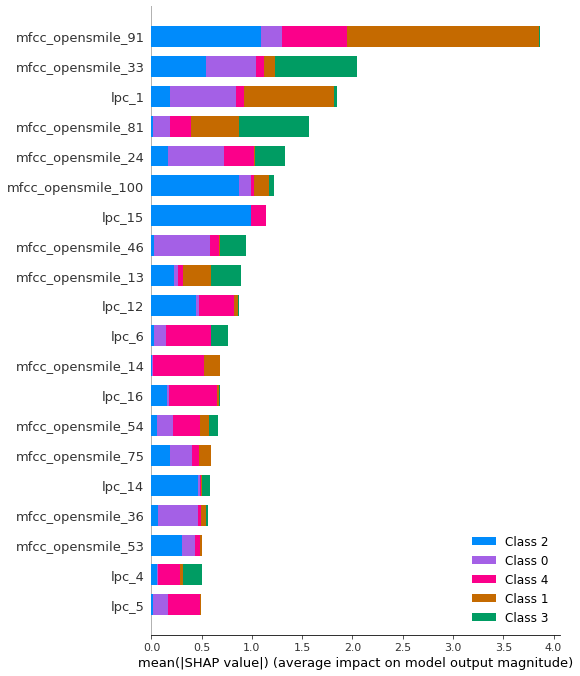

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_feat_tmp)
shap.summary_plot(shap_values, train_feat_tmp)

And we can see a confusion matrix of the mispredictions

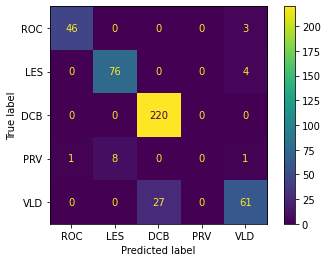

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_tmp))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

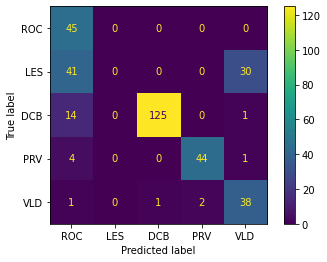

In [ ]:

confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_tmp))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()